In [3]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import numpy as np
import pandas as pd
from genealogy_aligner import Pedigree
import seaborn as sns
import matplotlib.pyplot as plt
from genealogy_aligner.Aligner import DescMatchingAligner
from genealogy_aligner.Drawing import draw_interactive
import msprime as msp
import io
from IPython.display import SVG, display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 1.0, 'Coalescent tree (diploid)')

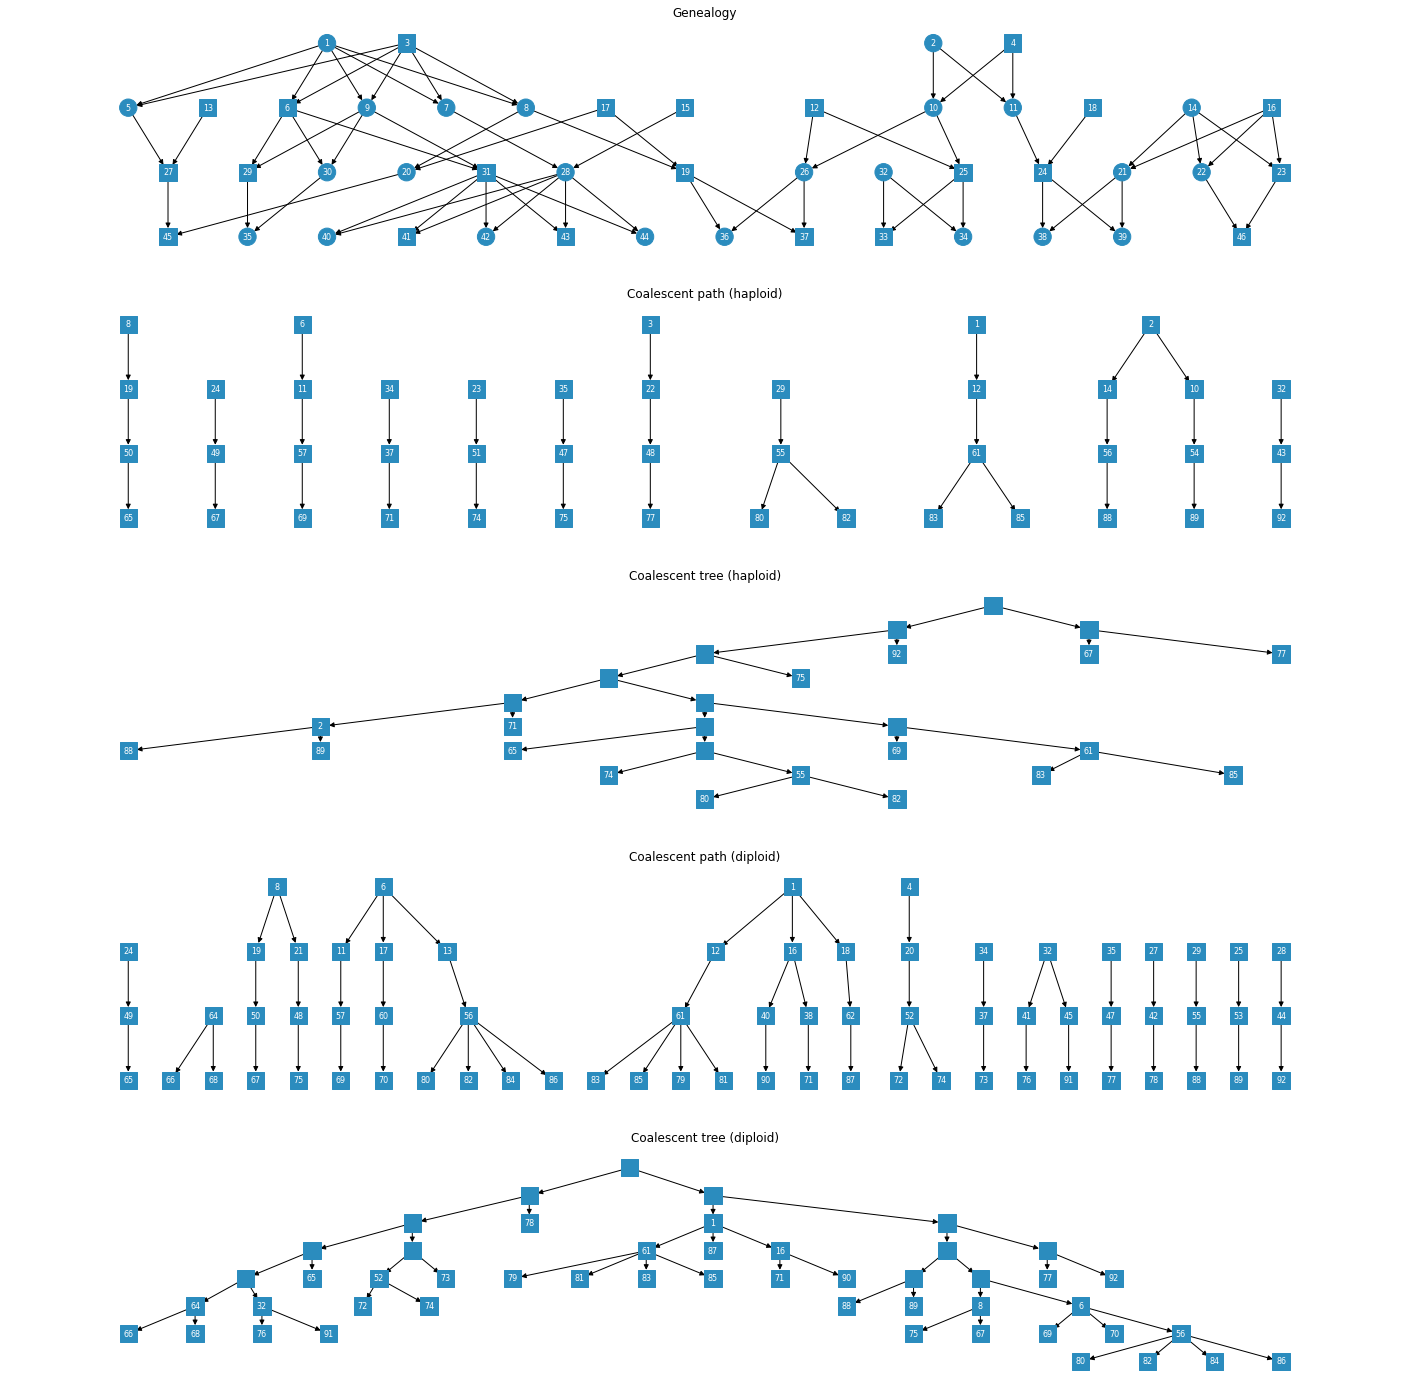

In [17]:
np.random.seed(724)

families = 3
generations = 3
avg_children = 2.2

ped = Pedigree.simulate_from_founders_with_sex(families, generations, avg_children)
h_graph = ped.get_haplotype_graph()

pt_1 = h_graph.sample_path(haploid_probands=True)
ct_1 = pt_1.to_coalescent_tree()

pt_2 = h_graph.sample_path()
ct_2 = pt_2.to_coalescent_tree()

fig, ax = plt.subplots(nrows=5, figsize=(25, 25))

ped.draw(ax=ax[0])
ax[0].set_title('Genealogy')

pt_1.draw(ax=ax[1], label_dict=pt_1.ts_node_to_ped_node)
ax[1].set_title('Coalescent path (haploid)')
ct_1.draw(ax=ax[2], label_dict=ct_1.ts_node_to_ped_node)
ax[2].set_title('Coalescent tree (haploid)')

pt_2.draw(ax=ax[3], label_dict=pt_2.ts_node_to_ped_node)
ax[3].set_title('Coalescent path (diploid)')
ct_2.draw(ax=ax[4], label_dict=ct_2.ts_node_to_ped_node)
ax[4].set_title('Coalescent tree (diploid)')

{'Node-Node Matching Accuracy': 0.8518518518518519, 'Proportion of Simple Symmetries': 0.0, 'Node-Edge Matching Accuracy': 0.07692307692307693}


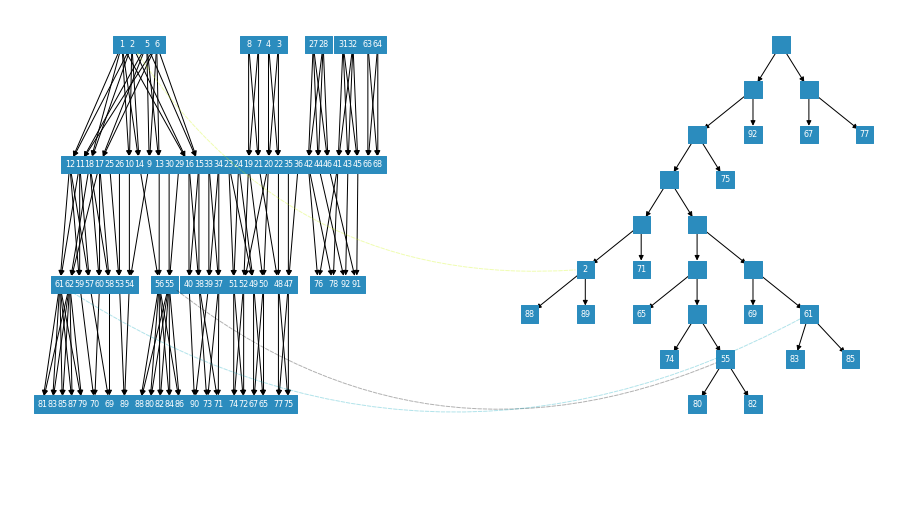

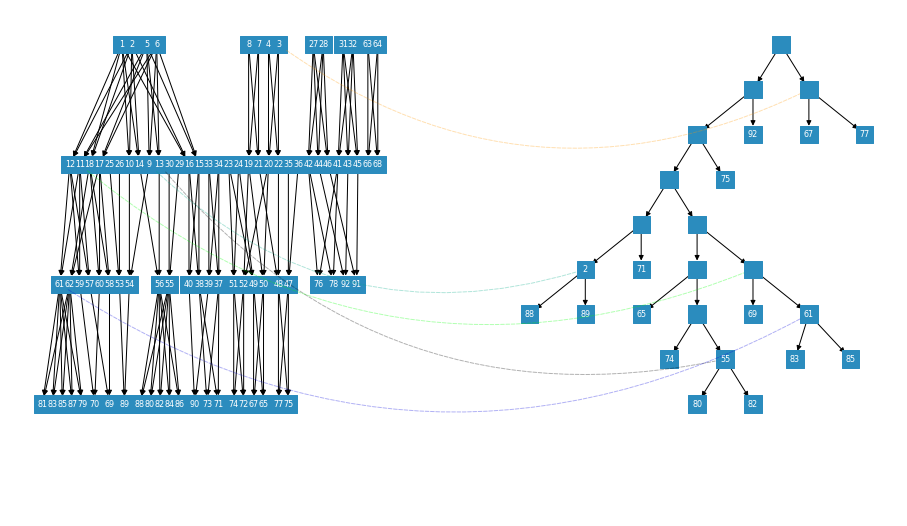

In [18]:
algn = DescMatchingAligner(h_graph, ct_1)
algn.align()
algn.complete_paths()
print(algn.evaluate()) # evaluate accuracy
# draw true vs. predicted
algn.draw()
plt.show()
algn.draw(use_predicted=True)

{'Node-Node Matching Accuracy': 0.8163265306122449, 'Proportion of Simple Symmetries': 0.3333333333333333, 'Node-Edge Matching Accuracy': 0.0625}


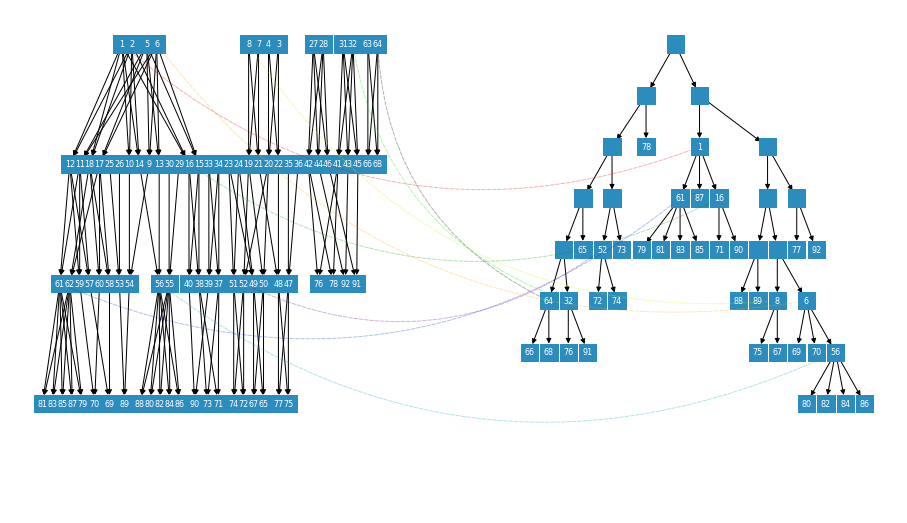

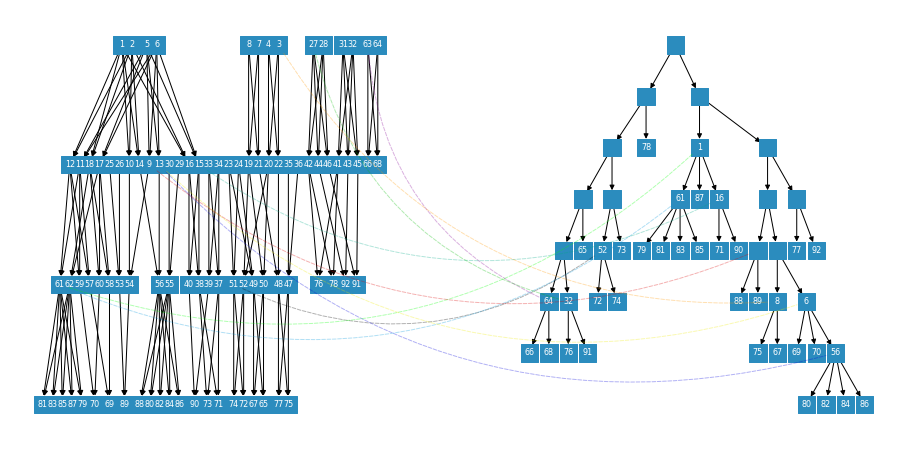

In [19]:
algn = DescMatchingAligner(h_graph, ct_2)
algn.align()
algn.complete_paths()
print(algn.evaluate()) # evaluate accuracy
# draw true vs. predicted
algn.draw()
plt.show()
algn.draw(use_predicted=True)

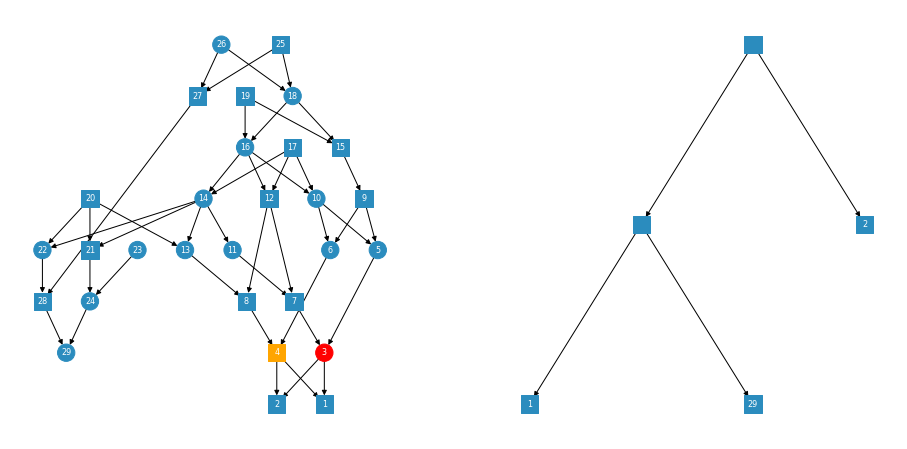

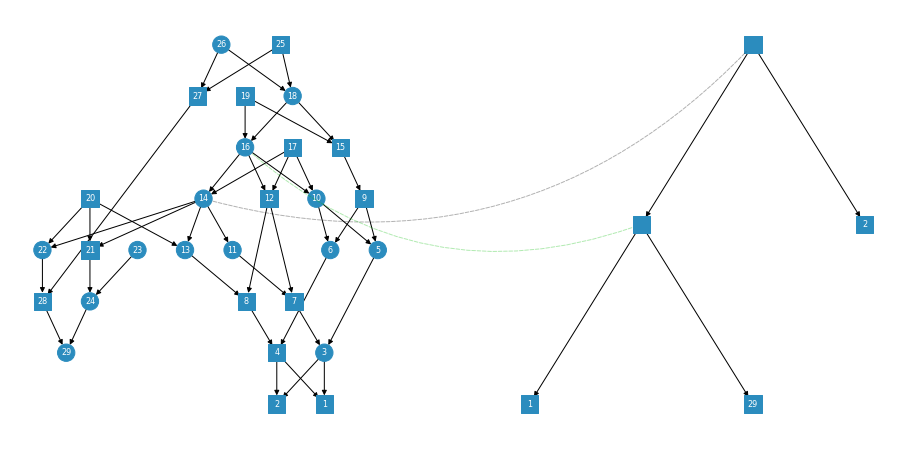

In [6]:
ped = Pedigree.from_table("../data/geneaJi.tsv", header=True, check_2_parents=False)
t = ped.sample_path()
ct = t.to_coalescent_tree()

algn = DescMatchingAligner(ped, ct)
algn.align()
algn.evaluate()

algn.draw(ped_kwargs={'node_color':{3: 'red', 4:'orange'}})
plt.show()
plt.close()
algn.draw(use_predicted=True)
plt.show()

In [8]:
draw_interactive(ped)

Text(value='', description='Node subset:', placeholder='List of nodes (comma separated)')

Text(value='1', description='Radius', placeholder='1')

Button(description='Plot', style=ButtonStyle())

Output()

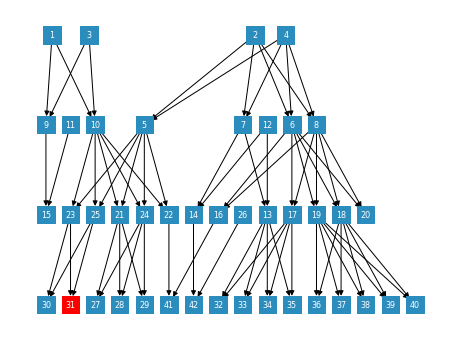

{23: {31: 1},
 25: {31: 1},
 10: {31: 2},
 5: {31: 2},
 1: {31: 2},
 2: {31: 2},
 3: {31: 2},
 4: {31: 2}}

In [119]:
ped.draw(node_color={31: 'red'})
plt.show()
ped.get_num_paths_to_target(31, include_target=False)

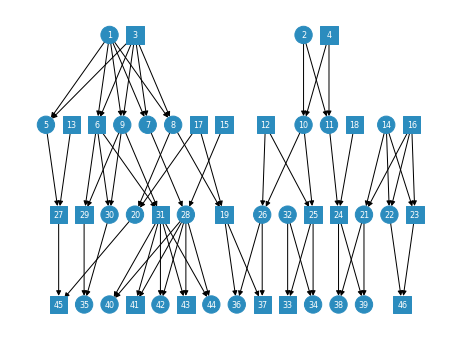

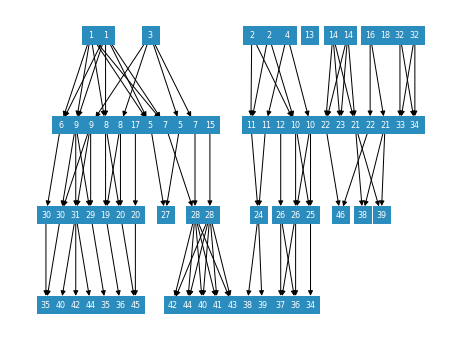

In [23]:
ped.draw()
plt.show()
x_graph = ped.get_haplotype_graph("X")
x_graph.draw(label_dict=x_graph.get_node_attributes('individual'))
plt.show()

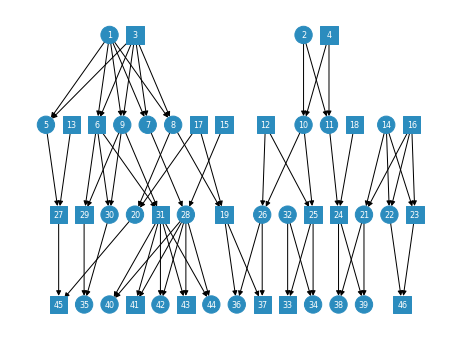

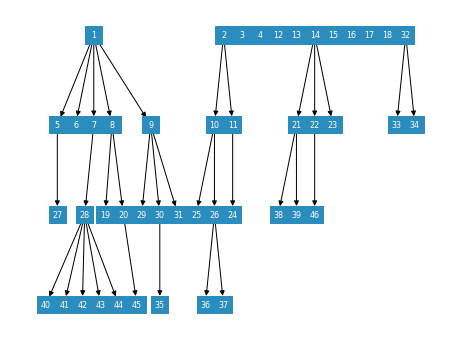

In [24]:
ped.draw()
plt.show()
mito_graph = ped.get_haplotype_graph("mitochondrial")
mito_graph.draw(label_dict=mito_graph.get_node_attributes('individual'))
plt.show()

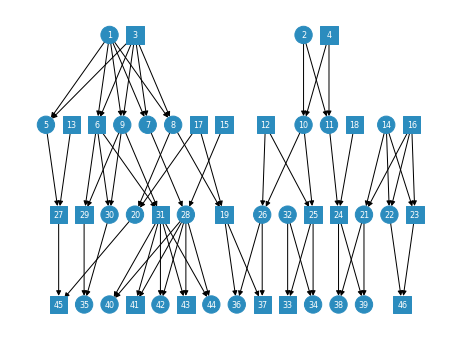

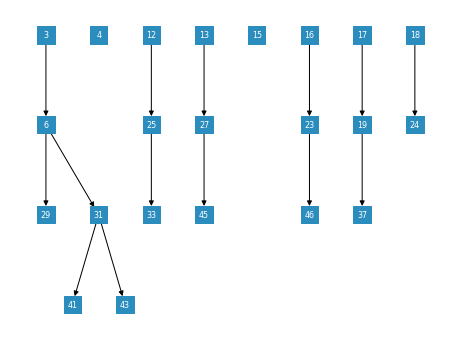

In [25]:
ped.draw()
plt.show()
y_graph = ped.get_haplotype_graph("Y")
y_graph.draw(label_dict=y_graph.get_node_attributes('individual'))
plt.show()